# Capstone Project - The Battle of the Neighborhoods (Week 2)
### *Applied Data Science Capstone by IBM/Coursera*

## Project title: Neighborhood scouting for real estate
#### Author: Elie Maze
#### Date: August 3rd, 2019

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The North America Privilege Estate company (NAPE), a real estate company, is specialized in the sell of high-standing properties in the United States and Canada. This company is aimed at a very demanding clientele.  
It always operates in the same way, the main steps are as follows:  
- define the customer's environmental needs in order to select and acquire the most appropriate land,
- define the architecture of the future property,
- etc.  
  
The company uses different specialists to complete all phases of the project. As mentioned earlier, one of them is to buy the land that best suits the needs of the customer. NAPE has often called on us to complete this phase of the project.  
A customer has used NAPE services recently. He wants to acquire a property in the North of the United States or in Canada. After several interviews with NAPE, 4 cities were selected:  
- Toronto,
- San-Francisco,
- New-York,
- Chicago.
  
It has passed on all of the client's criteria and asks us to send it the most suitable neighborhood to satisfy its client's needs:  
- the crime rate must be as low as possible,
- the land must be close to the greatest number of services, transportation, and medical facilities.
- In addition, the client likes to be entertained and to watch sports: he wants to enjoy a wide variety of restaurants, be able to go out at night and be as close as possible to stadiums and sports complexes, monuments and cultural sites.
- Finally he likes to swim and run so the housing must be near a pool or green areas.  
  
As the clientele of this company has a very high purchasing power, the price of land or properties does not enter into account.
The objective is to explore neighborhoods data and identify the top-5 neighborhoods which are the best compromise regarding all the criteria addressed by the customer.

## Data <a name="data"></a>

As the customer wants to be as close as possible to some specific kind of venues, we need to collect for each neighborhood of the 4 cities:
- the crime rate in the neighborhoods,  
- the number of distinct types of restaurants in the neighborhood,  
- the number of distinct types of entertainment venues for the night for the neighborhood,
- the average distance between the neighborhood and all the transport venues,
- the average distance between the neighborhood and all the common services in the city,
- the average distance between the neighborhood and the stadiums, the (baseball, ...) fields...
- the average distance between the neighborhood and the medical venues in the city,
- the average distance between the neighborhood and all the cultural venues in the city,
- the average distance between the neighborhood and the green areas (for running) or the swimming pools in the city.

### Data source
To identify the relevant venues and compute distances, we will fetch the location of each neighborhood (i.e. the centroid), then we will use the **Foursquare API** to get the venues plus the venue categories. We will use the module **geopy** to get the neighborhoods locations for some cities and also to compute distances.
  
| Data |NYC | Toronto | Chicago | San-Francisco |
|------|----|---------|---------|---------------|
| Neighborhood list | JSON file(1) | Wikipedia | Wikipedia | Wkipedia |
| Neighborhood location | JSON file(1) | CSV file(2) | Geopy | Geopy |
| Venues names & categories | Foursquare | Foursquare | Foursquare | Foursquare |
| Crime rate | Kaggle | Toronto Police portal | Kaggle | Kaggle |
  
(1) Coursera – Applied data-science capstone, week #3: Lab - Segmenting and Clustering Neighborhoods in New York City.  
(2) Coursera – Applied data-science capstone, week #3: Segmenting and Clustering Neighborhoods in the city of Toronto, Canada.

Here are all the modules we need to complete the project:

In [1]:
# Data / analytic
import pandas as pd
import numpy as np
from functools import reduce
import scipy
import operator
from math import ceil, sin, pi, sqrt

# Scrap / IO
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json

# ML
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Cartography
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy import distance
import folium # map rendering library

# Visualization
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

%matplotlib inline  

In [2]:
CLIENT_ID = 'VYRSRVUVIY4DJ4B1Y2LFY5IWSPP25CNSZKP5IJTAXNK4XUXO' # your Foursquare ID
CLIENT_SECRET = '4OUSV2ADEEKHFO2HGLBBKRC5SOP0OCZWW4SE5FG3ZUUK0HT3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Collect

The purpose of this section is to collect information about the neighborhoods of the 4 cities:
- the list of neighbourhoods and the locations,
- the crime rate for each neighborhood,
- the top-100 common venues (names & categories) given a radius from the neighborhood locations..
  
We will collect the crimes that were reported in each city in 2018. As the crimes are not always grouped by neighborhood, we will count the number of crimes occurring within a given radius from the centroid of each neighborhood (very time consuming). And fortunately the latitude/longitude are available for each dataset.  

In [3]:
# The columns names of the dataframes which contain raw data: neighborhood names + location + a unique identifier
COL_NAMES = ['uid', 'Neighborhood', 'Latitude', 'Longitude'] 

# Define the radius for searching venues using the Foursquare API and the occurrence of crimes.
RADIUS = 500  ## meters

Sometimes neighborhood names and locations are in separated sources. For some city we use the geopy module to fetch the neighborhood locations. Below is the function to get them:

In [5]:
def getNeighborhoodLocation(neighborhood, partial_address):
    """
    This function returns the latitude & longitude
    given an adress composed of the neighborhood name and the rest of the adress (city, state).
    """
    
    address = "{0}, {1}".format(neighborhood, partial_address)
    geolocator = Nominatim(user_agent="ny_explorer")
    location = None
    latitude, longitude = None, None
    i=0
    while location is None: ## overcome timeout issue
        try:
            location = geolocator.geocode(address)
            if not location is None:
                latitude = location.latitude
                longitude = location.longitude
            else: # No match
                return latitude, longitude
        except: # time-out or ...
            pass
        i+=1
        if i>100: break

    return latitude, longitude

Once we collect the raw data, we will plot the locations on a map,
so we need to define a function to get the location of each city to center the view of the map on the city:

In [6]:
def getCityLocation(address):
    """
    This function returns the latitude & longitude of a given city.
    """
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude

#### 1. New-York City

##### 1.1 NYC neighborhood names & locations
The objective is to read the JSON file to extract the neighborhood names & locations.  
So we develop the function below, it will returns a dataframe: ny_data.

As neighborhood names are not unique and since we need to merge this dataframe with another later,
we create a **UID** column (unique identifier) that is an incremental number.

In [7]:
def fetchNYdata(path='newyork_data.json'):
    with open(path) as json_data:
        newyork_data = json.load(json_data)

    # instantiate the dataframe
    df = pd.DataFrame(columns=COL_NAMES)
    
    print("\nFetch NYC raw data...")
    print("> Neighborhood data imported and useless columns have been removed.")

    uid = 0
    for data in newyork_data['features']:
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]

        df = df.append({'uid': uid,
                        'Neighborhood': neighborhood_name,
                        'Latitude': neighborhood_lat,
                        'Longitude': neighborhood_lon}, ignore_index=True)
        uid += 1
    
    df.dropna(inplace=True)
    df.reset_index(drop=True)
    df["uid"] = df.index.values
    df = df[COL_NAMES]

    print("> Neighborhood locations has been imported and merged with the neighborhood data.")
    print("> Dataframe is free of NaN.")
    print("> Dataframe shape:", df.shape)
    print("> Dataframe preview:")
    print("\n", df.head())
    
    return df

In [8]:
ny_data = fetchNYdata()


Fetch NYC raw data...
> Neighborhood data imported and useless columns have been removed.
> Neighborhood locations has been imported and merged with the neighborhood data.
> Dataframe is free of NaN.
> Dataframe shape: (306, 4)
> Dataframe preview:

    uid Neighborhood   Latitude  Longitude
0    0    Wakefield  40.894705 -73.847201
1    1   Co-op City  40.874294 -73.829939
2    2  Eastchester  40.887556 -73.827806
3    3    Fieldston  40.895437 -73.905643
4    4    Riverdale  40.890834 -73.912585


##### 1.2 NYC crimes
The functions belows are defined to:
1. Get the crimes rate with the location of occurrence,
2. Filter to keep only crimes occurring in 2018 and clean the output dataframe (drop nan, ...)
3. For each neighborhood, we compute the distance between its location and the location of all crimes. Then we filter the results to keep only crimes that occurred within a radius <= 500m from the neighborhood. Finally we count the number of crimes by neighborhood.

In [14]:
def CastCrimeDT(row):
    """
    This function is used to convert the column Date from string to datetime.
    The objective is to make this column more usable, because we want to filter data by year (keep only year 2018).
    Sometimes the column CMPLNT_FR_DT contains inconsistent data so we also try with column CMPLNT_TO_DT.
    """
    start_time = row["CMPLNT_FR_DT"]
    try:
        return pd.to_datetime(start_time, format="%m/%d/%Y")
    except:
        end_time = row["CMPLNT_TO_DT"]
        try:
            return pd.to_datetime(end_time, format="%m/%d/%Y")
        except: 
            pass # if date format or value is bad, it will returns a np.NaN and the record will be droped later.
    
    return np.NaN

def loadNYcrimes(path="ny_crimes.csv"):
    # Import data from file
    df = pd.read_csv(path, header=0, sep=",")
    
    # Keep only the date of occurrence and the postions:
    # CMPLNT_FR_DT: start date of the occurrence
    # CMPLNT_TO_DT: end date of the occurrence
    df = df[["CMPLNT_FR_DT", "CMPLNT_TO_DT", "Latitude", "Longitude"]]
    
    print("\nFetch NYC crimes data...")
    print("> Crimes data imported and useless columns have been removed.")
    
    # Cast the string representation of the date as a datetime64
    df["Date"] = df.apply(CastCrimeDT, axis=1)
    print("> dates as been casted to datetime64")
    print("> Dataframe column types:\n")
    print(df.dtypes, "\n")
    
    # Filter dataframe to keep only crimes that occurred in 2018.
    mask = (df.Date.dt.year==2018)
    df = pd.DataFrame( df[mask] )
    df.drop(["CMPLNT_FR_DT", "CMPLNT_TO_DT", "Date"], axis=1, inplace=True)
    df.dropna(inplace=True)
    
    print("> Dataframe has been filtered (keep only crimes in 2018)")
    print("  and only positions are preserved in the output dataframe.")
    print("> Dataframe shape:", df.shape)
    print("> Dataframe preview:")
    print("\n", df.head())
    
    return df

In [10]:
ny_crimes = loadNYcrimes()


Fetch NYC crimes data...
> Crimes data imported and useless columns have been removed.
> dates as been casted to datetime64
> Dataframe column types:

CMPLNT_FR_DT            object
CMPLNT_TO_DT            object
Latitude               float64
Longitude              float64
Date            datetime64[ns]
dtype: object 

> Dataframe has been filtered (keep only crimes in 2018)
  and only positions are preserved in the output dataframe.
> Dataframe shape: (102913, 2)
> Dataframe preview:

     Latitude  Longitude
0  40.653751 -73.931609
1  40.644726 -74.077483
2  40.715434 -73.737816
3  40.744414 -73.889065
4  40.681967 -73.982367


In [8]:
def getCrimesNbFromRadius(row, crimes):
    neighborhood_pos = row[["Latitude", "Longitude"]].tolist()
    filtered_crimes = filter(lambda x: x<=RADIUS, map(lambda x: distance.distance(neighborhood_pos, x).meters, crimes))
    return reduce(lambda count, item: count + 1, filtered_crimes, 0)

In [12]:
ny_data["Crimes"] = ny_data.apply(lambda x: getCrimesNbFromRadius(x, ny_crimes.values), axis=1)
ny_data.to_csv("ny_proc_data.csv", sep=";", encoding="utf-8")
ny_data.head()

,uid,Neighborhood,Latitude,Longitude,Crimes
0,0,Wakefield,40.894705,-73.847201,91
1,1,Co-op City,40.874294,-73.829939,75
2,2,Eastchester,40.887556,-73.827806,60
3,3,Fieldston,40.895437,-73.905643,7
4,4,Riverdale,40.890834,-73.912585,24


##### 1.3 NYC Map
Now let's plot each neigborhood on map centered on NYC.
The radius of each scatter is related to the number of crimes occuring within a radius <= 500m.

In [7]:
ny_data = pd.read_csv("ny_proc_data.csv", sep=";", encoding="utf-8", index_col=0)

ny_lat, ny_long = getCityLocation('NYC')
print('The geograpical coordinate of New-York are {}, {}.'.format(ny_lat, ny_long))

# create map of NYC using latitude and longitude values
map_ny = folium.Map(location=[ny_lat, ny_long], zoom_start=10)

# add markers to map
crimes_log = ny_data['Crimes'].map(np.log1p)
max_crimes = crimes_log.max()
crimes_log = 5*(crimes_log+1)
for lat, lng, label, crime, size in zip(ny_data['Latitude'], ny_data['Longitude'], ny_data['Neighborhood'], ny_data['Crimes'], crimes_log):
    label = label+", crimes: "+str(crime)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=size/max_crimes,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  
    
map_ny

The geograpical coordinate of New-York are 40.7127281, -74.0060152.


#### 2. Toronto

##### 2.1 Toronto neighborhood names & locations
The objective is to fetch the neighborhood names from Wikipedia, then to get the locations from a CSV file (Coursera).  
So we develop the function below, it will returns a dataframe: toronto_data.

In [16]:
def fetchNcleanTorontoData(url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"):
    # fetch data
    df = pd.read_html(url, header=0)[0]
    
    print("\nFetch Toronto raw data...")
    print("> Neighborhood data imported.")
    
    # Remove rows when Borough is not assigned
    df["Borough"] = df["Borough"].replace({"Not assigned": np.nan})
    df = df.dropna(axis=0) # Remove rows
    print("> Records containing unassigned boroughs have been droped.")
    
    # Replace neighborhood names by the borough name when neighborhood is unassigned
    mask = (df["Neighbourhood"]=="Not assigned")
    df.loc[mask, "Neighbourhood"] = df["Borough"]
    print("> Mentions \'unassigned\' in column Neighborhood have been replaced by the borough names.")
    
    # Group neighbourhoods that have the same postal code
    # More than one neighborhood can exist in one postal code area.
    # Combined rows which have the same borough into one row with the neighborhoods separated with a comma
    df = df.groupby(by=['Postcode', 'Borough'])["Neighbourhood"].apply(', '.join).reset_index(drop=False)
    print("> Duplicated neighborhoods have been cleaned.")
    
    # Append neighborhood locations
    # In order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.
    # We will read the CSV file which contains the latitude & longitude for each postcode and save it as a temporary dataframe called 'tmp'.
    # Then this dataframe will merged with the dataframe 'cleaned_data'.
    url_loc = "Toronto_coordinates.csv"
    tmp = pd.read_csv(url_loc, sep=",", encoding="utf-8")
    tmp.columns = ["Postcode", "Latitude", "Longitude"]
    df = df.merge(tmp, how="left", on="Postcode")
    
    df.drop(["Postcode", "Borough"], axis=1, inplace=True)
    df.columns = COL_NAMES[1:]
    df.dropna(inplace=True)
    df.reset_index(drop=True)
    df["uid"] = df.index.values
    df = df[COL_NAMES]
    
    print("> Neighborhood locations have been appended and the dataframe has been cleaned.")
    print("> Dataframe shape:", df.shape)
    print("> Dataframe preview:")
    print("\n", df.head())
    
    return df

In [17]:
toronto_data = fetchNcleanTorontoData()


Fetch Toronto raw data...
> Neighborhood data imported.
> Records containing unassigned boroughs have been droped.
> Mentions 'unassigned' in column Neighborhood have been replaced by the borough names.
> Duplicated neighborhoods have been cleaned.
> Neighborhood locations have been appended and the dataframe has been cleaned.
> Dataframe shape: (103, 4)
> Dataframe preview:

    uid                            Neighborhood   Latitude  Longitude
0    0                          Rouge, Malvern  43.806686 -79.194353
1    1  Highland Creek, Rouge Hill, Port Union  43.784535 -79.160497
2    2       Guildwood, Morningside, West Hill  43.763573 -79.188711
3    3                                  Woburn  43.770992 -79.216917
4    4                               Cedarbrae  43.773136 -79.239476


##### 2.2 Toronto crimes
We redefine a function to collect and filter crime rate for the last 3 cities,  
because the format of the input files for the 3 cities is not the same than the one for NYC.  
It's not a big difference, files contains a column year (int) so it's easier to filter the dataframe, 
we do not need to cast any column.

In [50]:
def loadCrimes(path, sep, col_year, col_lat, col_long):
    # Import data from file
    df = pd.read_csv(path, header=0, sep=sep)
    
    # Keep only the year of occurrence and the postions:
    df = df[[col_year, col_lat, col_long]]
    
    # Drop records with missing values
    df.dropna(inplace=True)
    
    print("\nFetch crimes data...")
    print("> Crimes data imported, useless columns have been removed and records with missing data have been droped.")
    
    # Filter dataframe to keep only crimes that occurred in 2018.
    mask = (df[col_year]==2018)
    df = pd.DataFrame( df[mask] )
    df.drop(col_year, axis=1, inplace=True)
    
    df.rename({col_lat:"Latitude", col_long:"Longitude"}, axis=1, inplace=True)
    
    print("> Dataframe has been filtered (keep only crimes in 2018)")
    print("  and only positions are preserved in the output dataframe.")
    print("> Dataframe shape:", df.shape)
    print("> Dataframe preview:")
    print("\n", df.head())
    
    return df

In [21]:
toronto_crimes = loadCrimes(path="toronto_crimes_2014_to_2018.csv", 
                            sep=",",
                            col_year="occurrenceyear",
                            col_lat="Lat",
                            col_long="Long")


Fetch crimes data...
> Crimes data imported, useless columns have been removed and records with missing data have been droped.
> Dataframe has been filtered (keep only crimes in 2018)
  and only positions are preserved in the output dataframe.
> Dataframe shape: (35382, 2)
> Dataframe preview:

        Latitude  Longitude
8009  43.654957 -79.375877
8010  43.640335 -79.437920
8011  43.802563 -79.232048
8012  43.691235 -79.288361
8013  43.691235 -79.288361


In [51]:
toronto_data["Crimes"] = toronto_data.apply(lambda x: getCrimesNbFromRadius(x, toronto_crimes.values), axis=1)
toronto_data.to_csv("toronto_proc_data.csv", sep=";", encoding="utf-8")
toronto_data.head()

,uid,Neighborhood,Latitude,Longitude,Crimes
0,0,"Rouge, Malvern",43.806686,-79.194353,5
1,1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,11
2,2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,162
3,3,Woburn,43.770992,-79.216917,15
4,4,Cedarbrae,43.773136,-79.239476,45


#####  2.3 Toronto Map
Now let's plot each neigborhood on map centered on Toronto.
The radius of each scatter is related to the number of crimes occuring within a radius <= 500m.

In [8]:
toronto_data = pd.read_csv("toronto_proc_data.csv", sep=";", encoding="utf-8")

toronto_lat, toronto_long = getCityLocation('Toronto, Ontario')
print('The geograpical coordinate of Toronto are {}, {}.'.format(toronto_lat, toronto_long))

# create map of NYC using latitude and longitude values
map_toronto = folium.Map(location=[toronto_lat, toronto_long], zoom_start=10)

# add markers to map
crimes_log = toronto_data['Crimes'].map(np.log1p)
max_crimes = crimes_log.max()
crimes_log = 5*(crimes_log+1)
for lat, lng, label, crime, size in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood'], toronto_data['Crimes'], crimes_log):
    label = label+", crimes: "+str(crime)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=size/max_crimes,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### 3. Chicago

##### 3.1 Chicago neighborhood names & locations
The neighborhood names are fetched from Wikipedia and saved as chicago_neighborhood.csv.  
We just need to read the CSV file, then the locations are extracted for each neighborhood using the module geopy.  
Before, we just have to generate the address of the neighborhoods.

In [22]:
def fetchNcleanChicagoData(path="chicago_neighborhoods.csv"):
    # fetch data
    df = pd.read_csv(path, header=0, sep=";")
    
    print("\nFetch Chicago raw data...")
    print("> Neighborhood data imported.")
    
    # append locations
    tmp = df["Neighborhood"].map(lambda x: getNeighborhoodLocation(x, "Chicago, Illinois"))
    df = df.merge(tmp.apply(pd.Series), left_index=True, right_index=True)
    df.columns = COL_NAMES[1:]
    df.dropna(inplace=True)
    df.reset_index(drop=True)
    df["uid"] = df.index.values
    df = df[COL_NAMES]
    
    print("> Neighborhood locations have been appended and the dataframe has been cleaned.")
    print("> Dataframe shape:", df.shape)
    print("> Dataframe preview:")
    print("\n", df.head())
    
    return df

In [23]:
chicago_data = fetchNcleanChicagoData()


Fetch Chicago raw data...
> Neighborhood data imported.
> Neighborhood locations have been appended and the dataframe has been cleaned.
> Dataframe shape: (77, 4)
> Dataframe preview:

    uid    Neighborhood   Latitude  Longitude
0    0     Albany Park  41.971937 -87.716174
1    1  Archer Heights  41.811422 -87.726165
2    2   Armour Square  41.840033 -87.633107
3    3         Ashburn  41.747533 -87.711163
4    4  Auburn Gresham  41.750474 -87.664304


#####  3.2 Chicago crimes

In [55]:
chicago_crimes = loadCrimes(path="Chicago_Crimes_2018.csv",
                            sep=";",
                            col_year="Year",
                            col_lat="Latitude",
                            col_long="Longitude")


Fetch crimes data...
> Crimes data imported, useless columns have been removed and records with missing data have been droped.
> Dataframe has been filtered (keep only crimes in 2018)
  and only positions are preserved in the output dataframe.
> Dataframe shape: (263441, 2)
> Dataframe preview:

     Latitude  Longitude
0  41.763181 -87.657709
1  41.689079 -87.696064
2  41.740521 -87.647391
3  41.857068 -87.657625
4  41.751914 -87.647717


In [56]:
chicago_data["Crimes"] = chicago_data.apply(lambda x: getCrimesNbFromRadius(x, chicago_crimes.values), axis=1)
chicago_data.to_csv("chicago_proc_data.csv", sep=";", encoding="utf-8")
chicago_data.head()

,uid,Neighborhood,Latitude,Longitude,Crimes
0,0,Albany Park,41.971937,-87.716174,415
1,1,Archer Heights,41.811422,-87.726165,198
2,2,Armour Square,41.840033,-87.633107,322
3,3,Ashburn,41.747533,-87.711163,183
4,4,Auburn Gresham,41.750474,-87.664304,1332


#####  3.3 Chicago Map
Now let's plot each neigborhood on map centered on Chicago.
The radius of each scatter is related to the number of crimes occuring within a radius <= 500m.

In [9]:
chicago_data = pd.read_csv("chicago_proc_data.csv", sep=";", encoding="utf-8")

chicago_lat, chicago_long = getCityLocation('Chicago, Illinois')
print('The geograpical coordinate of Chicago are {}, {}.'.format(chicago_lat, chicago_long))

# create map of NYC using latitude and longitude values
map_chicago = folium.Map(location=[chicago_lat, chicago_long], zoom_start=10)

# add markers to map
crimes_log = chicago_data['Crimes'].map(np.log1p)
max_crimes = crimes_log.max()
crimes_log = 5*(crimes_log+1)
for lat, lng, label, crime, size in zip(chicago_data['Latitude'], chicago_data['Longitude'], chicago_data['Neighborhood'], chicago_data['Crimes'], crimes_log):
    label = label+", crimes: "+str(crime)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=size/max_crimes,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


#### 4. San-Francisco

##### 4.1 SF neighborhood names & locations
The neighborhood names are fetched from Wikipedia and saved as sf_neighborhood.csv.  
We just need to read the CSV file, then the locations are extracted for each neighborhood using the module geopy.  
Beforen we just have to generate the address of the neighborhoods.

In [26]:
def fetchNcleanSFData(path="sf_neighborhood.csv"):
    # fetch data
    df = pd.read_csv(path, header=0, sep=";")
    
    print("\nFetch San-Fransisco raw data...")
    print("> Neighborhood data imported.")
    
    # append locations
    tmp = df["Neighborhood"].map(lambda x: getNeighborhoodLocation(x, "SF, CA"))
    df = df.merge(tmp.apply(pd.Series), left_index=True, right_index=True)
    df.columns = COL_NAMES[1:]
    df.dropna(inplace=True)
    df.reset_index(drop=True)
    df["uid"] = df.index.values
    df = df[COL_NAMES]
    
    print("> Neighborhood locations have been appended and the dataframe has been cleaned.")
    print("> Dataframe shape:", df.shape)
    print("> Dataframe preview:")
    print("\n", df.head())
    
    return df

In [27]:
sf_data = fetchNcleanSFData()


Fetch San-Fransisco raw data...
> Neighborhood data imported.
> Neighborhood locations have been appended and the dataframe has been cleaned.
> Dataframe shape: (94, 4)
> Dataframe preview:

    uid  Neighborhood   Latitude   Longitude
0    0  Alamo Square  37.776357 -122.434694
1    1    Anza Vista  37.780836 -122.443149
3    3   Balboa Park  37.724949 -122.444805
5    5       Bayview  37.728889 -122.392500
6    6  Belden Place  37.791744 -122.403886


##### 4.2 SF crimes

In [58]:
sf_crimes = loadCrimes(path="SF_crimes.csv",
                       sep=",",
                       col_year="Incident Year",
                       col_lat="Latitude",
                       col_long="Longitude")


Fetch crimes data...
> Crimes data imported, useless columns have been removed and records with missing data have been droped.
> Dataframe has been filtered (keep only crimes in 2018)
  and only positions are preserved in the output dataframe.
> Dataframe shape: (146667, 2)
> Dataframe preview:

       Latitude   Longitude
136  37.766871 -122.416549
234  37.777400 -122.407015
298  37.752852 -122.408189
325  37.763572 -122.417332
449  37.777579 -122.497455


In [59]:
sf_data["Crimes"] = sf_data.apply(lambda x: getCrimesNbFromRadius(x, sf_crimes.values), axis=1)
sf_data.to_csv("sf_proc_data.csv", sep=";", encoding="utf-8")
sf_data.head()

,uid,Neighborhood,Latitude,Longitude,Crimes
0,0,Alamo Square,37.776357,-122.434694,1845
1,1,Anza Vista,37.780836,-122.443149,1230
3,3,Balboa Park,37.724949,-122.444805,580
5,5,Bayview,37.728889,-122.392500,1277
6,6,Belden Place,37.791744,-122.403886,5032


#####  4.3 SF Map
Now let's plot each neigborhood on map centered on San-Francisco.
The radius of each scatter is related to the number of crimes occuring within a radius <= 500m.

In [10]:
sf_data = pd.read_csv("sf_proc_data.csv", sep=";", encoding="utf-8")

sf_lat, sf_long = getCityLocation('SF, California')
print('The geograpical coordinate of San-Francisco are {}, {}.'.format(sf_lat, sf_long))

# create map of NYC using latitude and longitude values
map_sf = folium.Map(location=[sf_lat, sf_long], zoom_start=10)

# add markers to map
crimes_log = sf_data['Crimes'].map(np.log1p)
max_crimes = crimes_log.max()
crimes_log = 5*(crimes_log+1)
for lat, lng, label, crime, size in zip(sf_data['Latitude'], sf_data['Longitude'], sf_data['Neighborhood'], sf_data['Crimes'], crimes_log):
    label = label+", crimes: "+str(crime)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=size/max_crimes,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sf)  
    
map_sf

The geograpical coordinate of San-Francisco are 37.7792808, -122.4192363.


#### 5. Append the venues - Foursquare

##### Functions
We will use the same function for the 4 cities (dataframes).    
The function below was found in the notebook:  
  \> Coursera – Applied data-science capstone, week #3: Lab - Segmenting and Clustering Neighborhoods in New York City.  
  
The objective is to use the Foursquare API to get the top-100 common venues within a radius from a given position (i.e. in our case: the neighborhood location).

In [11]:
# define the parameters
LIMIT = 100  # limit of number of venues returned by Foursquare API

# Function to repeat the same process to all the neighborhoods in Toronto : concatenate toronto_data and venues information (name, category)
def getNearbyVenues(uids, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for uid, lat, lng in zip(uids, latitudes, longitudes):
   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(uid,
                             v['venue']['name'],
                             v['venue']['location']['lat'],
                             v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['uid',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']
    
    return(nearby_venues)

This function below will just execute the function above and save the result as a CSV file.

In [12]:
def appendLocations(df, path_out):
    # Enrich data with foursquare API
    venues = getNearbyVenues(uids=df['uid'],
                             latitudes=df['Latitude'],
                             longitudes=df['Longitude'],
                             radius=RADIUS)

    venues.to_csv(path_out, sep=";", encoding="utf-8")
    
    return venues

##### 5.1 Execution

###### NYC

In [36]:
ny_data = pd.read_csv("ny_proc_data.csv", sep=";", encoding="utf-8")
ny_venues = appendLocations(ny_data, "ny_venues.csv")
print("New-York venues shape:", ny_venues.shape)
print('There are {} uniques venue categories.'.format(len(ny_venues['Venue Category'].unique())))

New-York venues shape: (10382, 5)
There are 427 uniques venue categories.


In [41]:
ny_venues.head()

,uid,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,0,Rite Aid,40.896649,-73.844846,Pharmacy
2,0,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,0,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant
4,0,Dunkin',40.890459,-73.849089,Donut Shop


###### Totonto

In [61]:
toronto_data = pd.read_csv("toronto_proc_data.csv", sep=";", encoding="utf-8")
toronto_venues = appendLocations(toronto_data, "toronto_venues.csv")
print("Toronto venues shape:", toronto_venues.shape)
print('There are {} uniques venue categories.'.format(len(toronto_venues['Venue Category'].unique())))

Toronto venues shape: (2241, 5)
There are 280 uniques venue categories.


In [62]:
toronto_venues.head()

,uid,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,1,Royal Canadian Legion,43.782533,-79.163085,Bar
2,2,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,2,G & G Electronics,43.765309,-79.191537,Electronics Store
4,2,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


###### Chicago

In [63]:
chicago_data = pd.read_csv("chicago_proc_data.csv", sep=";", encoding="utf-8")
chicago_venues = appendLocations(chicago_data, "chicago_venues.csv")
print("Chicago venues shape:", chicago_venues.shape)
print('There are {} uniques venue categories.'.format(len(chicago_venues['Venue Category'].unique())))

Chicago venues shape: (1473, 5)
There are 246 uniques venue categories.


In [64]:
chicago_venues.head()

,uid,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Chicago Produce,41.970553,-87.716327,Grocery Store
1,0,Cairo Nights Hookah Lounge,41.975776,-87.715547,Hookah Bar
2,0,Nighthawk,41.967974,-87.713415,Cocktail Bar
3,0,Popeyes Louisiana Kitchen,41.968459,-87.713156,Fried Chicken Joint
4,0,Peking Mandarin Resturant,41.968292,-87.715783,Chinese Restaurant


###### San-Francisco

In [65]:
sf_data = pd.read_csv("sf_proc_data.csv", sep=";", encoding="utf-8")
sf_venues = appendLocations(sf_data, "sf_venues.csv")
print("San-Fransisco venues shape:", sf_venues.shape)
print('There are {} uniques venue categories.'.format(len(sf_venues['Venue Category'].unique())))

San-Fransisco venues shape: (4947, 5)
There are 349 uniques venue categories.


In [66]:
sf_venues.head()

,uid,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Alamo Square,37.776060,-122.434606,Park
1,0,Alamo Square Dog Park,37.775878,-122.435740,Dog Run
2,0,Painted Ladies,37.776120,-122.433389,Historic Site
3,0,The Independent,37.775573,-122.437835,Rock Club
4,0,The Mill,37.776425,-122.437970,Bakery


### Data processing and features creation

At this moment:
- on the first hand we have dataframes containing the neighborhood names and locations plus the number of crimes,  
- on the other hand, we have dataframes that contain the venue names and catagories for each neighborhood (uid).  
  
The problem is that we are just interested in venues related to a few venue types.  
So we have to take a glance at the list of the venue categories (from the 4 cities) and manually create a mapping between these venue categories and the final categories that are:
- Food (Restaurants, Stakehouse...),
- Medical Care (medical venues),
- transport (the intra-city transports, excluding boats and planes),
- Night-Entertainment (the entertainment venues for the night: clubs, pubs, pool halls,...),
- Nature-Sport (the venues for running or to swim),
- Culture (the cultural venues: Theater, Opera, Monuments, Museums...),
- Entertainment (the venues to watch sport: stadiums, baseball fields, complexes...),
- Services (the common services like bank, post offices, lawyers...).
- Others: the other venue categories. These venues won't be took into account.

In [13]:
ny_venues = pd.read_csv("ny_venues.csv", sep=";", encoding="utf-8")
toronto_venues = pd.read_csv("toronto_venues.csv", sep=";", encoding="utf-8")
chicago_venues = pd.read_csv("chicago_venues.csv", sep=";", encoding="utf-8")
sf_venues = pd.read_csv("sf_venues.csv", sep=";", encoding="utf-8")

First get the venue categories found in the 4 cities, then merged these data, remove the duplicates and finally export data to a CSV file.

In [16]:
# Gather all the venue categories found in the 4 cities
categories = set(toronto_venues['Venue Category'].tolist()+ny_venues['Venue Category'].tolist()+sf_venues['Venue Category'].tolist()+chicago_venues['Venue Category'].tolist())

# save the list of categories find in the 4 cities
df_cat = pd.DataFrame(list(categories))
df_cat.columns = ['Venue Category']
df_cat.to_csv("Venue_categories.csv")

# statistics
print("There are {0} unique venue categories in the 4 cities".format(len(categories)))

There are 505 unique venue categories in the 4 cities


After a quite long analysis in Excel and in Google, we create a dict that is used as the mapping.  
Then we define a function (below) to apply the mapping.

In [16]:
cat = {}
cat["Medical Care"] = ["Drugstore", "Pharmacie", "Pharmacy", "Health", "Hospital", "Medical", "Doctor", "Doctor's", "Therapist", "Chiropractor"]
cat["Transport"] = ["Taxi", "Bus", "Moving", "Metro", "Train", "Rail"]

cat["Night-Entertainment"] = ["Other Nightlife", "Bowling Alley", "Beer Garden", "Pool Hall", "Nightclub", "Strip", "Bodega",
                              "Roof Deck", "Brewery", "Bar", "Pub", "Rock Club"]

cat["Food"] = ["Cafeteria", "Buffet", "Wings", "Poke", "Soup", "Snack", "Noodle", "BBQ", "Salad", "Bistro", "Cheese", "Lounge",
               "Food", "Taco", "Creperie", "Burrito", "Fried", "Diner", "Burger", "Gastro", "Restaurant", "Steakhouse",
               "Sandwich", "Pizza", "Ice Cream", "Tea Room", "Café", "Coffee", "Breakfast", "Hot Dog"]

cat["Nature-Sport"] = ["River", "Hill", "Trail", "Lake", "Beach", "Outdoors", "Park", "Pool", "Nature Preserve"]

cat["Culture"] = ["Poutine Place", "Outdoor Sculpture", "Memorial Site", "Monument / Landmark", "Historic Site",
                  "Exhibit", "Museum", "Art", "Cultural Center", "Theater", "Opera", "Recording", "Jazz Club",
                  "Jazz", "Music", "Concert", "Comedy Club", "Multiplex"]

cat["Entertainment"] = ["Hockey", "Curling Ice", "Soccer Field", "Stadium", "Baseball Field"]

cat["Services"] = ["Lawyer", "Home Service", "Financial or Legal Service", "Post", "Bank", "Insurance", "Garage", "Workshop", "ATP", "Barbershop"]

def normalizeCat(cell):
    
    for norm_cat, venue_cat in cat.items():
        if list(filter(lambda x: x in cell, venue_cat)): return norm_cat
    
    return "Other"

The result returned by the function above is stored as a new column called "Final_Category".  
Statistics:

In [22]:
df_cat['Final_Category'] = df_cat['Venue Category'].map(normalizeCat)

print("Number of Venue categories per Final category")
tmp = pd.DataFrame(df_cat.groupby("Final_Category")["Venue Category"].count())
tmp.columns = ["Venue categories count"]
tmp.sort_values("Venue categories count")

Number of Venue categories per Final category


,Venue categories count
Final_Category,
Services,8
Transport,9
Entertainment,10
Medical Care,10
Nature-Sport,18
Night-Entertainment,30
Culture,31
Food,143
Other,246


Now we have implemented the mapping and tested it, we can apply it on the 4 dataframes and complete the features creation.  
Here are the steps of the process:
1. Apply the mapping and create the column 'final_Category',
2. Group the venues_data and apply the aggregation function nunique to count the distinct types of venues related to the final category 'Food' and 'Night-Entertainment' so we have a new dataframe called 'features_grouped',  
3. Append the crimes to the features_grouped dataframe,
4. Compute the average distance between each neighborhood location and all venues related to:
    * Transport
    * Services
    * Stadium, complexes...
    * Medical
    * Culture
    * Nature-Sport
  
Finally we have 9 features, these new columns will be appended to features_grouped dataframe.

In [17]:
# Define the aggregation opetations for a few columns (final categories).
agg_functions = {}
agg_functions['Food'] = "nunique"                 ## Don't include NaN in the count
agg_functions['Night-Entertainment'] = "nunique"  ## Don't include NaN in the count


# Returns the average distance between neighborhoods and venues
def computeDist(row, sites):
    neighborhood_pos = row[["Latitude", "Longitude"]].tolist()
    return round(reduce(operator.add, map(lambda x: distance.distance(neighborhood_pos, x).meters, sites))/len(sites), 2)


# Process data, create the features
def createFeatures(filename_rdata, filename_venues):
    # load data
    #
    #  cols: uid, Neighborhood, Latitude, Longitude, Crimes
    raw_data = pd.read_csv(filename_rdata, sep=";", encoding="utf-8")
    
    #  cols: uid, Venue, Venue Latitude, Venue Longitude, Venue Category
    venues_data = pd.read_csv(filename_venues, sep=";", encoding="utf-8")
    
    # normalize categories
    venues_data['Final_Category'] = venues_data['Venue Category'].map(normalizeCat)

    # Prepare the columns to count distinct categories
    venues_data["Food"] = np.NaN
    mask = (venues_data.Final_Category=="Food")
    venues_data.loc[mask, 'Food'] = venues_data['Venue Category']

    venues_data["Night-Entertainment"] = np.NaN
    mask = (venues_data.Final_Category=="Night-Entertainment")
    venues_data.loc[mask, 'Night-Entertainment'] = venues_data['Venue Category']
    
    # Create dataframe features from venues_data with only useful columns
    features = pd.DataFrame()
    features['uid'] = venues_data['uid'] 
    features['Food'] = venues_data['Food'] 
    features['Night-Entertainment'] = venues_data['Night-Entertainment'] 
    
    # Group the rows by uid (i.e. Neighborhood).
    # (Some neighborhoods from different boroughs have the same name)
    features_grouped = features.groupby("uid").agg(agg_functions)
    features_grouped = features_grouped.reset_index(drop=False)
    
    # Append crimes, neighborhood names, latitudes & longitudes from dataframe raw_data by merging on the uid.
    features_grouped = features_grouped.merge(raw_data[["uid", "Neighborhood", "Latitude", "Longitude", "Crimes"]], how="left", on="uid")
    features_grouped.drop("uid", axis=1, inplace=True)
    
    # extract the location of the services in the city then compute distance
    transports = venues_data.loc[venues_data.Final_Category=="Transport", ["Venue Latitude", "Venue Longitude"]].values
    features_grouped["Transport_distance"] = features_grouped.apply(lambda x: computeDist(x, transports), axis=1)
    
    # extract the location of the services in the city then compute distance
    services = venues_data.loc[venues_data.Final_Category=="Services", ["Venue Latitude", "Venue Longitude"]].values
    features_grouped["Service_distance"] = features_grouped.apply(lambda x: computeDist(x, services), axis=1)
    
    # extract the location of the stadiums in the city then compute distance
    stadiums = venues_data.loc[venues_data.Final_Category=="Entertainment", ["Venue Latitude", "Venue Longitude"]].values
    features_grouped["Stadium_distance"] = features_grouped.apply(lambda x: computeDist(x, stadiums), axis=1)
    
    # extract the location of the medical venues in the city then compute distance
    medical_cares = venues_data.loc[venues_data.Final_Category== "Medical Care", ["Venue Latitude", "Venue Longitude"]].values
    features_grouped["Medical_distance"] = features_grouped.apply(lambda x: computeDist(x, medical_cares), axis=1)
    
    # extract the location of the culture venues in the city then compute distance
    medical_cares = venues_data.loc[venues_data.Final_Category== "Culture", ["Venue Latitude", "Venue Longitude"]].values
    features_grouped["Culture_distance"] = features_grouped.apply(lambda x: computeDist(x, medical_cares), axis=1)
    
    # extract the location of the Natural/Sport venues in the city then compute distance
    medical_cares = venues_data.loc[venues_data.Final_Category== "Nature-Sport", ["Venue Latitude", "Venue Longitude"]].values
    features_grouped["Nature-Sport_dist"] = features_grouped.apply(lambda x: computeDist(x, medical_cares), axis=1)
    
    return features_grouped

Now that the functions are defined, we will execute them for each city.  
We will get 4 new dataframes containing:  
- the neighborhood information : neighborhood names & location,
- the 9 features (crimes, Food, ...).

#### 1. NYC

In [18]:
ny_features = createFeatures("ny_proc_data.csv", "ny_venues.csv")
print("shape of ny_features:", ny_features.shape)
ny_features.head()

shape of ny_features: (304, 12)


,Food,Night-Entertainment,Neighborhood,Latitude,Longitude,Crimes,Transport_distance,Service_distance,Stadium_distance,Medical_distance,Culture_distance,Nature-Sport_dist
0,4,0,Wakefield,40.894705,-73.847201,91,24242.34,22450.49,26122.66,21794.76,22135.47,24207.80
1,5,1,Co-op City,40.874294,-73.829939,75,22961.58,21052.71,24889.13,20506.10,21077.66,22959.86
2,6,3,Eastchester,40.887556,-73.827806,60,24145.45,22298.05,26088.19,21745.23,22328.80,24209.00
3,0,0,Fieldston,40.895437,-73.905643,7,23653.48,21944.76,25205.44,20983.67,20362.15,23033.64
4,1,0,Riverdale,40.890834,-73.912585,24,23244.81,21548.39,24742.11,20525.05,19744.63,22509.59


#### 2. Toronto

In [19]:
toronto_features = createFeatures("toronto_proc_data.csv", "toronto_venues.csv")
print("shape of toronto_features:", toronto_features.shape)
toronto_features.head()

shape of toronto_features: (100, 12)


,Food,Night-Entertainment,Neighborhood,Latitude,Longitude,Crimes,Transport_distance,Service_distance,Stadium_distance,Medical_distance,Culture_distance,Nature-Sport_dist
0,1,0,"Rouge, Malvern",43.806686,-79.194353,5,17962.17,18688.19,21531.18,22230.30,22825.51,21866.20
1,0,1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,11,18539.57,19808.06,22151.64,23239.90,23221.86,22633.27
2,3,0,"Guildwood, Morningside, West Hill",43.763573,-79.188711,162,15487.44,16995.25,19086.10,20337.74,20053.99,19594.79
3,3,0,Woburn,43.770992,-79.216917,15,14125.83,15258.51,17724.11,18834.84,18820.16,18144.31
4,4,0,Cedarbrae,43.773136,-79.239476,45,13005.17,13958.72,16552.21,17585.58,17702.32,16888.60


#### 3. Chicago

In [20]:
chicago_features = createFeatures("chicago_proc_data.csv", "chicago_venues.csv")
print("shape of chicago_features:", chicago_features.shape)
chicago_features.head()

shape of chicago_features: (75, 12)


,Food,Night-Entertainment,Neighborhood,Latitude,Longitude,Crimes,Transport_distance,Service_distance,Stadium_distance,Medical_distance,Culture_distance,Nature-Sport_dist
0,7,2,Albany Park,41.971937,-87.716174,415,14854.24,10734.44,18852.03,11363.96,10733.63,15830.83
1,6,1,Archer Heights,41.811422,-87.726165,198,12254.49,13269.35,21048.42,12429.31,14654.90,13386.24
2,7,1,Armour Square,41.840033,-87.633107,322,10584.25,10996.90,21613.51,9439.31,11173.47,11333.13
3,1,0,Ashburn,41.747533,-87.711163,183,15152.73,18512.96,26455.37,17099.48,19863.64,16242.55
4,4,0,Auburn Gresham,41.750474,-87.664304,1332,14181.69,17804.07,27275.91,16211.03,19074.59,15186.14


#### 4. San-Francisco

In [21]:
sf_features = createFeatures("sf_proc_data.csv", "sf_venues.csv")
print("shape of sf_features:", sf_features.shape)
sf_features.head()

shape of sf_features: (94, 12)


,Food,Night-Entertainment,Neighborhood,Latitude,Longitude,Crimes,Transport_distance,Service_distance,Stadium_distance,Medical_distance,Culture_distance,Nature-Sport_dist
0,25,5,Alamo Square,37.776357,-122.434694,1845,3540.10,4292.64,4089.23,2862.18,2642.67,3360.75
1,6,1,Anza Vista,37.780836,-122.443149,1230,3879.45,4322.33,4644.95,3100.33,3118.77,3704.78
2,5,0,Balboa Park,37.724949,-122.444805,580,4208.64,5800.79,7531.77,5855.29,6447.09,5735.64
3,5,0,Bayview,37.728889,-122.392500,1277,5538.67,6728.18,5884.86,6043.06,6142.41,6111.28
4,28,9,Belden Place,37.791744,-122.403886,5032,5691.38,5258.98,2763.05,3578.53,2774.42,4055.66


#### 5. Merge all dataframes
Now we can merge the 4 dataframes to get a single one, but before we want to add a new column that contains the city name to be able to retrieve the city of the neighborhoods that we will select at the end of this project.

In [22]:
ny_features["City"] = "New-York City"
toronto_features["City"] = "Totonto"
chicago_features["City"] = "Chicago"
sf_features["City"] = "San-Fransisco"

features = pd.concat((ny_features, toronto_features, chicago_features, sf_features), axis=0)
features = features.reset_index(drop=True)
print(features.shape)
features.head()

(573, 13)


,Food,Night-Entertainment,Neighborhood,Latitude,Longitude,Crimes,Transport_distance,Service_distance,Stadium_distance,Medical_distance,Culture_distance,Nature-Sport_dist,City
0,4,0,Wakefield,40.894705,-73.847201,91,24242.34,22450.49,26122.66,21794.76,22135.47,24207.80,New-York City
1,5,1,Co-op City,40.874294,-73.829939,75,22961.58,21052.71,24889.13,20506.10,21077.66,22959.86,New-York City
2,6,3,Eastchester,40.887556,-73.827806,60,24145.45,22298.05,26088.19,21745.23,22328.80,24209.00,New-York City
3,0,0,Fieldston,40.895437,-73.905643,7,23653.48,21944.76,25205.44,20983.67,20362.15,23033.64,New-York City
4,1,0,Riverdale,40.890834,-73.912585,24,23244.81,21548.39,24742.11,20525.05,19744.63,22509.59,New-York City


## Methodology <a name="methodology"></a>

Humans cannot explore manually a dozen variables for hundreds of neighborhoods in order to find the top-5.  
The approach here is to transcribe the customer’s criteria as features for all neighborhoods (already done) and clusterize the neighborhoods.  
The second step consists in comparing the clusters and identify the group of neighborhoods that best fits the needs of the customer then we should have a smaller amount of neighborhoods to analyze.  

### Analysis <a name="analysis"></a>

Let's save the column names that contain information related to the neighborhoods as NEIGHBORHOOD_COLS,  
and those which are our 9 features as FEATURES_COLS. Would be easier to manipulate dataframes later.

In [23]:
FEATURES_COLS = [ c for c in features.columns if not c in COL_NAMES ]
FEATURES_COLS.remove("City")
FEATURES_COLS

['Food',
 'Night-Entertainment',
 'Crimes',
 'Transport_distance',
 'Service_distance',
 'Stadium_distance',
 'Medical_distance',
 'Culture_distance',
 'Nature-Sport_dist']

In [24]:
NEIGHBORHOOD_COLS = COL_NAMES + ["City"]
NEIGHBORHOOD_COLS.remove("uid")
NEIGHBORHOOD_COLS

['Neighborhood', 'Latitude', 'Longitude', 'City']

#### Distribution
Let's draw histgrams for each features:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000242CFED7978>,
      dtype=object)

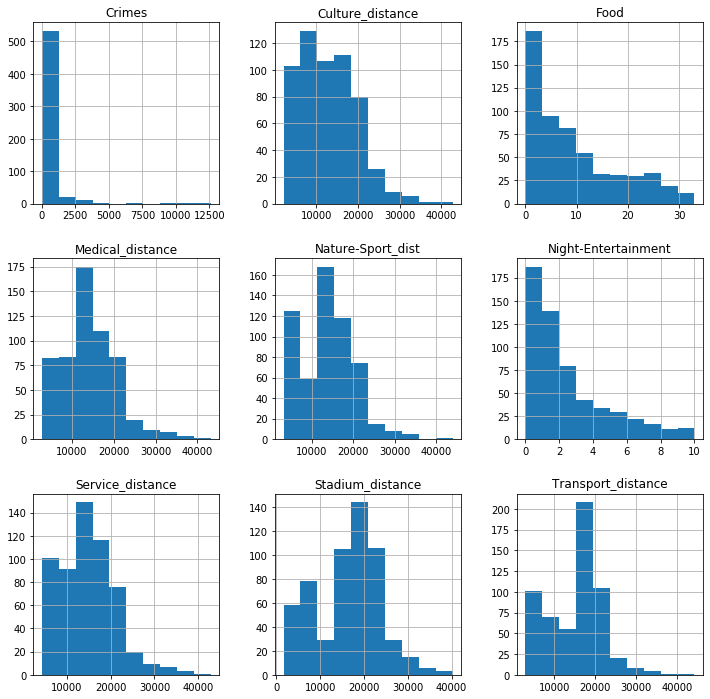

In [25]:
features[FEATURES_COLS].hist(figsize=(12,12))

*Histogram observations:*  
1. We observe that the distribution of the 9 features is approximately log-normal.  ML model works better with normal distribution, furthermore such distribution is more appropriate for the next function which will try to help us to select a good number of clusters.  So we will apply a np.log1p transformation to all features in order to get 'gaussian-like' distributions.  
  
  
2. The value ranges of the 9 features are very different. The selection of the best neighborhoods is based on these features. As we want to consider all of them with the same importance and because the comparison of these features in a graph is not realistic when the value range are very different, we will scale data between 0 & 1 with the MinMaxScaler of scikit-learn.  

*Note:*  
The solution should maximize the features:
- Food
- Night-Entertainment  
  
And minimize the features:  
- Crimes
- Medical / Nature-Sport / Service / Stadium / Transport / Culture distances  
  
  
To make this easier, especially when representing features on a graph, we will apply the 1-x transformation after the scaling to the 7 features that we wanted to minimize. After this operation, we will just have to maximize all features.

The code below is intended to apply the np.log1p transformation, scale the features and apply the 1-x transformation to 7 features:

In [26]:
features_proc = features.copy(True)
for col in FEATURES_COLS:
    features_proc[col] = features_proc[col].astype(float)
    features_proc[col] = features_proc[col].map(np.log1p)
    
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(features_proc[FEATURES_COLS])

features_proc = pd.concat( (features_proc[NEIGHBORHOOD_COLS], pd.DataFrame(X)), axis=1)
features_proc.columns = NEIGHBORHOOD_COLS + FEATURES_COLS

for col in FEATURES_COLS:
    if "distance" in col or "Crimes" in col:
        features_proc[col] = 1.00 - features_proc[col]
    
features_proc.head()

,Neighborhood,Latitude,Longitude,City,Food,Night-Entertainment,Crimes,Transport_distance,Service_distance,Stadium_distance,Medical_distance,Culture_distance,Nature-Sport_dist
0,Wakefield,40.894705,-73.847201,New-York City,0.456402,0.000000,0.521127,0.223702,0.280327,0.135166,0.249643,0.221322,0.770083
1,Co-op City,40.874294,-73.829939,New-York City,0.508104,0.289065,0.541360,0.243865,0.308150,0.150309,0.271844,0.237805,0.749711
2,Eastchester,40.887556,-73.827806,New-York City,0.551818,0.578130,0.564644,0.225189,0.283276,0.135579,0.250472,0.218395,0.770102
3,Fieldston,40.895437,-73.905643,New-York City,0.000000,0.000000,0.779780,0.232837,0.290188,0.146356,0.263458,0.249430,0.750946
4,Riverdale,40.890834,-73.912585,New-York City,0.196562,0.000000,0.659110,0.239311,0.298077,0.152164,0.271508,0.259797,0.742088


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000242D22196D8>,
      dtype=object)

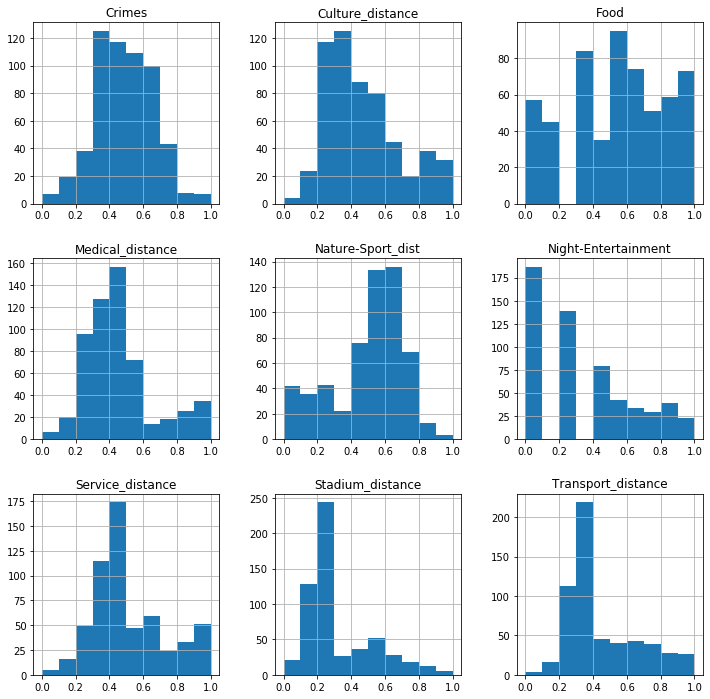

In [27]:
features_proc[FEATURES_COLS].hist(figsize=(12,12))

*Histograms observations:*  
The log1p transformation do not give us the expected results for all features, but at least it does the job for some of them like Crimes or Culture_distance.

### Clustering

The function below will be use to carry out the neighborhoods clustering with K-means (Scikit-learn) given a value for the numbre of clusters (k):

In [31]:
def clustering(df, k):
    # get features
    X = df[FEATURES_COLS]

    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    
    # add the cluster number as a new column
    df["cluster"] = kmeans.labels_

Let's try with nb_clusters = 3.  
Below is the distribution of the 3 clusters.

Text(0.5, 0.98, 'Distribution of the cluster number')

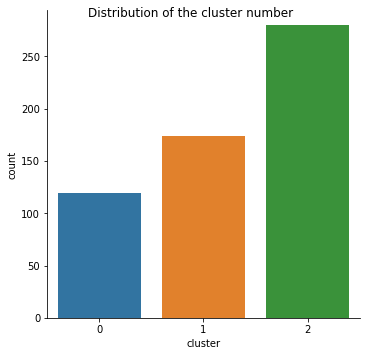

In [32]:
nb_clusters = 3
clustering(features_proc, nb_clusters)
graph = sns.catplot(x="cluster", data=features_proc, kind="count")
graph.fig.suptitle('Distribution of the cluster number')

Now let's draw the distriubtion of the 9 features per cluster.  
As we have 3 clusters, we plot 3 curves per graph.

In [33]:
def drawDistributions(df, nb_clusters, wrap=3, figsize=(20,15)):
    
    tmp = df.copy(deep=True)
    tmp.drop(NEIGHBORHOOD_COLS, axis=1, inplace=True)

    cluster_labels = [str(i) for i in range(nb_clusters)]

    cols = list(tmp.columns)
    cols.remove("cluster")

    nb_graphs = len(cols)
    nb_rows = ceil(nb_graphs/wrap)

    fig, axes = plt.subplots(nrows=nb_rows, ncols=wrap, figsize=figsize)

    for i, column in enumerate(cols):
        axes[i//wrap, i%wrap].set_title(column)
        for k in range(nb_clusters):
            sns.distplot(tmp.loc[df.cluster==k, column].values, hist=False, ax=axes[i//wrap, i%wrap], label=str(k))

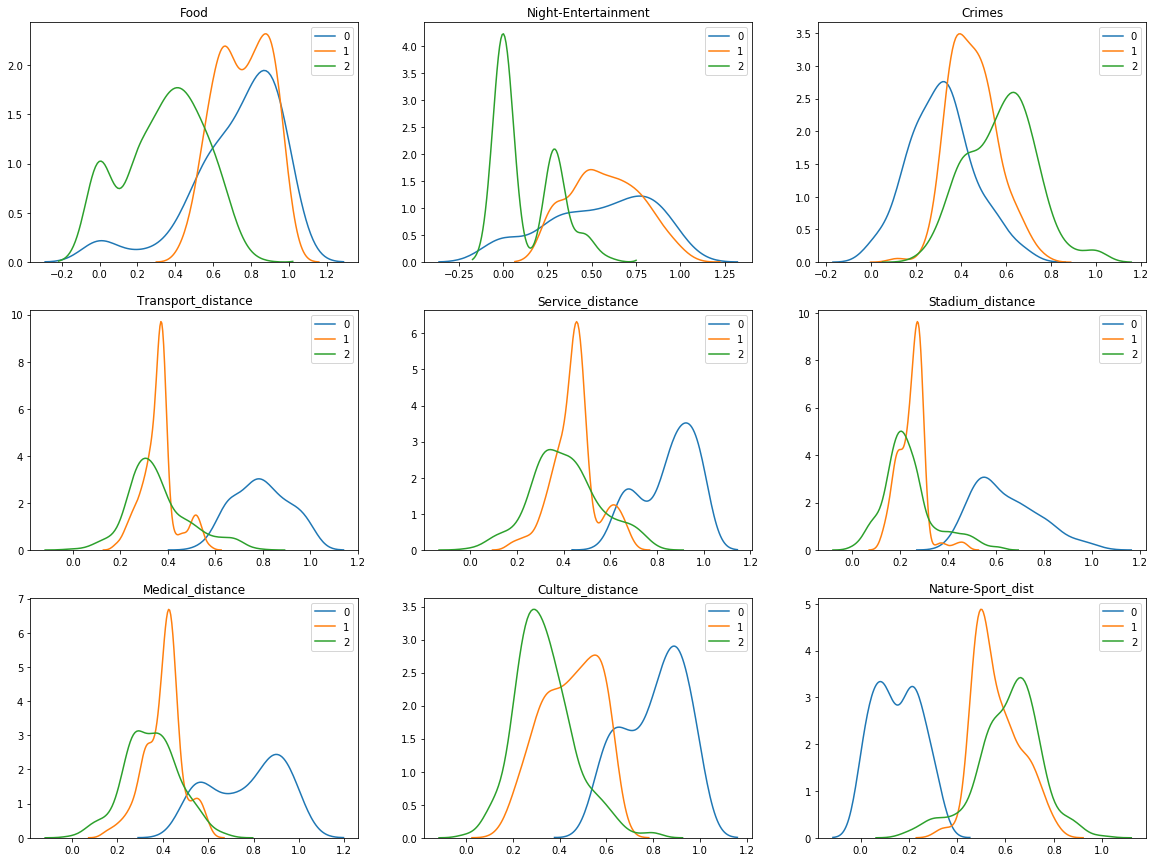

In [34]:
drawDistributions(features_proc, nb_clusters)

By clustering neighborhoods, we expect to get 3 distinct distributions for each features.  
We observe that for some features, the distributions are quite distinct (culture_distance or Crimes), but sometimes the distribution overlap a little bit (Food) or are bi-modal (Night-Entertainment).  
Now we will try to define a better value for the number of clusters to get better distributions.

So to get more distinct distributions, we try a "naive" methods that:
- maximize the delta between the averages of the distributions of the 3 clusters to have well separated distributions.
- and minimize the standard deviation (these are approximately gaussian distributions) to have less spread distributions.  
  
The function below will return an indicator for a given feature.  
We will have a dataframe that contains 9 indicators (columns) to be maximized for several possible values of k (number of clusters) (rows).

In [35]:
def getClusterIndicator(df, nb_clusters, feat_name):
    
    # store the average value & standard deviation of values along a given column (feature name) for each k (cluster number).
    avgs = [] ## store average values
    stds = [] ## store standard deviations
    for k in range(0, nb_clusters):
        mask = (df["cluster"]==k)
        avg = df.loc[mask, feat_name].mean()
        std = df.loc[mask, feat_name].std()
        avgs.append(avg)
        stds.append(std)
    
    # Compute the delta between each distribution of k
    # the delta formula is: SQRT( [Ai-Aj]² ) / (1 + Si*Sj)
    # A: average
    # S: standard deviation
    # Then the returned value is Sum(delta)/n , n: nb of delta
    l=0
    dist = 0
    for i in range(0,len(avgs)-1,1):
        for j in range(i+1, len(avgs),1):
            dist += sqrt((avgs[i]-avgs[j])**2)/(1+stds[i]*stds[j])
            l += 1
    
    return dist/l

In [36]:
def computeIndicators(df):
    df_indicators = pd.DataFrame(columns=["clusters"]+FEATURES_COLS)

    index=0
    for k in range(3,12):

        clustering(df, k)

        row = [k]
        for col in FEATURES_COLS:
            row.append(getClusterIndicator(df, k, col))

        df_indicators.loc[index] = row
        index+=1
    
    return df_indicators

def drawSpiderChart(df, serie_name="clusters"):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, polar=True)
    angles = np.linspace(0, 2*np.pi, len(FEATURES_COLS), endpoint=False) # Set the angles
    angles = np.concatenate(( angles, [angles[0]] ))                     # Close the polygon

    kmin = df[serie_name].astype(int).min()
    kmax = df[serie_name].astype(int).max()
    for k in range(kmin,kmax+1):
        values = df.loc[df[serie_name]==k, FEATURES_COLS].values[0] # Get the values
        values = np.concatenate(( values, [values[0]] ))         # Close the polygon
        ax.plot(angles, values, 'o-', linewidth=2, label=str(k)) # Draw the curve

    ax.set_thetagrids(angles * 180/np.pi, FEATURES_COLS) # Set the label for each axis
    ax.set_title("Mean values for each clusters") 
    ax.grid(True)
    ax.legend()

The code below executes the functions above in order to get the dataframe with the indicators for the 9 features.  
We have arbitrary choosen a range of k to explore between 3 and 11: so 9 values for k.
The 9 indicators for the 9 values of k are drawn as curves the radar chart below.

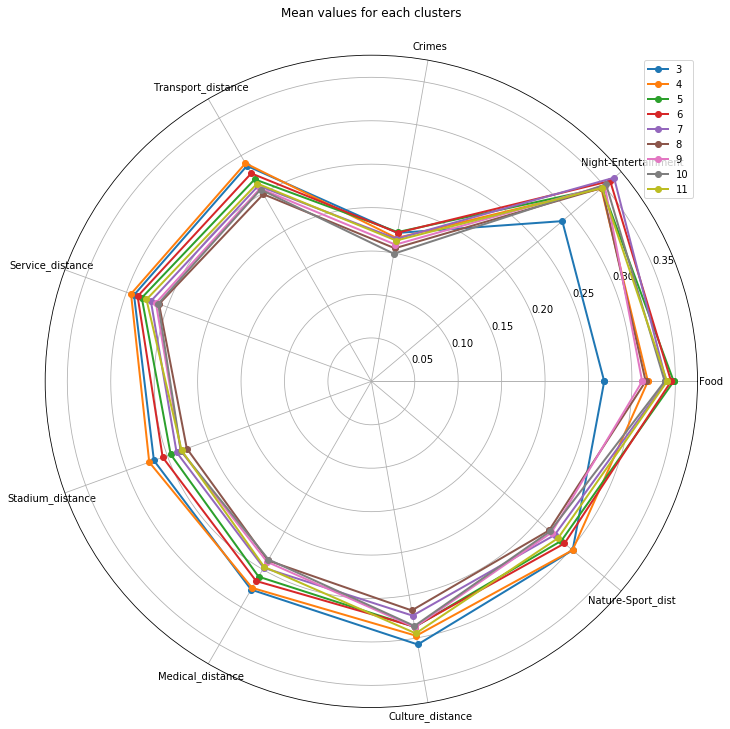

In [37]:
indicators = computeIndicators(features_proc)
drawSpiderChart(indicators)

The best curve should maximize all the 9 indicators. So we adopt a "naive" approach (again) that consists in calculating the area under the curves and select the highest one. It should give a good compromise.  
To compute the area under each curve, we decomposed the radar in multiple triangles. So we just have to sum the area of the 8 triangles which is done with the function below.

<table>
    <tr>
        <td><img src="triangle.PNG"></td>
        <td>Area(ABC) = 0.5 * b * c * sin(BAC)</td>
    </tr>
</table>

In [38]:
def computeArea(row):
    area = 0.0
    for sega, segb in zip(row[:-1], row[1:]):
        area += sega*segb
    area += row[-1]*row[0]  ## compute the last triangle area to close the curve.
    return area*0.5*sin(360*pi/(180*len(row)))

In [39]:
tmp = pd.DataFrame(indicators.set_index("clusters").apply(computeArea, axis=1).sort_values(ascending=False))
tmp.columns = ["Area under spider curve"]
tmp

,Area under spider curve
clusters,
4.0,0.232814
6.0,0.229439
5.0,0.222527
3.0,0.215380
11.0,0.213061
7.0,0.211612
10.0,0.201775
9.0,0.200173
8.0,0.192474


In [40]:
print("The best value of k for an appropriate clustering seems to be: {0}".format(tmp.idxmax().values[0]))

The best value of k for an appropriate clustering seems to be: 4.0


The next step consists in do the clustering into 4 groups and select the best cluster.

Text(0.5, 0.98, 'Distribution of the cluster number')

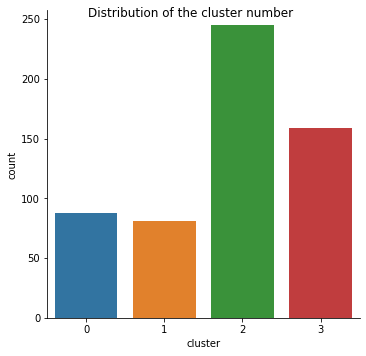

In [41]:
nb_clusters = 4
clustering(features_proc, nb_clusters)
graph = sns.catplot(x="cluster", data=features_proc, kind="count")
graph.fig.suptitle('Distribution of the cluster number')

Again we draw the distribution for each feature per group to check if the clustering is better.

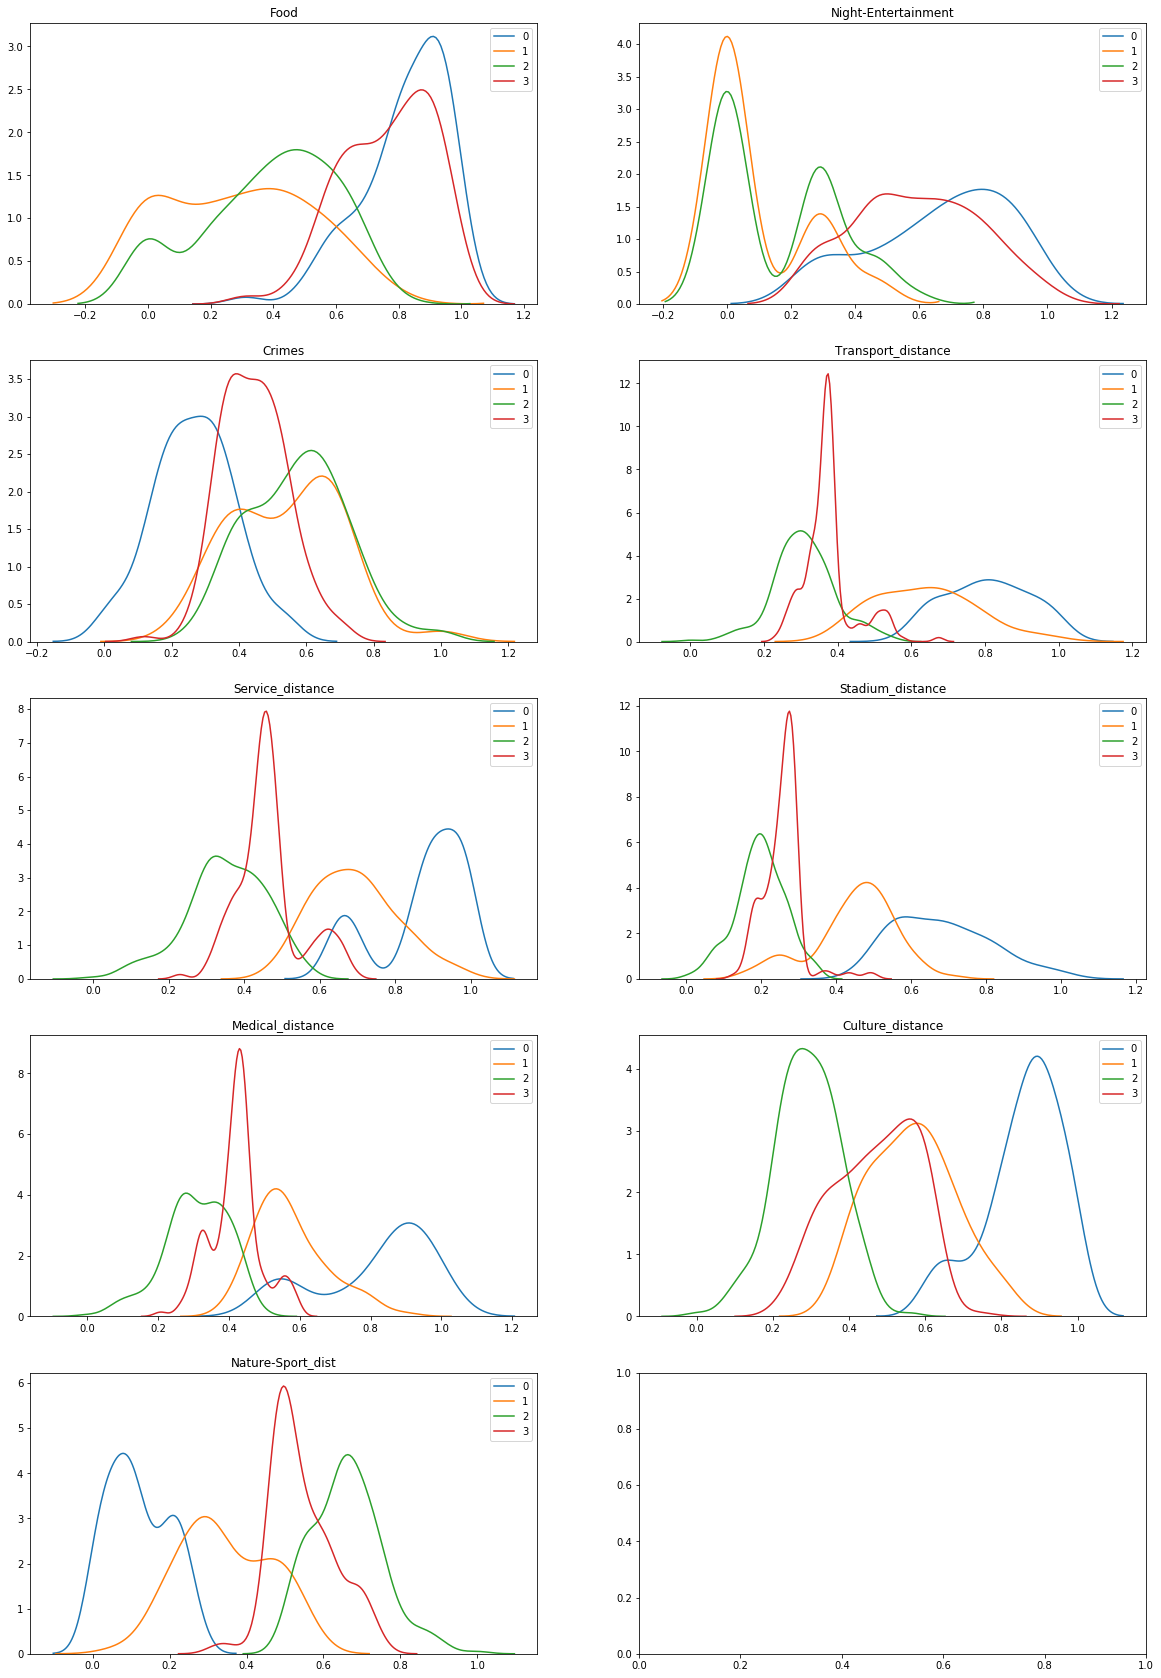

In [181]:
drawDistributions(features_proc, nb_clusters, wrap=2, figsize=(20,30))

What we can say is that indeed the use of 4 clusters improve a little bit the clustering.  
It's quite the same distributions but the modes are slightly shifted apart and the 4th group does not always overlap the 3 others distributions, example : Nature-Sport_dist.

As the best cluster should maximize each features, we would like to indentify a cluster whose distributions are always on the right of each graph.  
Of course we observe that is not possible, the ideal which would satisfy all the criteria does not exist but at least we can identify the best compromise.  
It seems the blue curve (group 0) have distributions that are the closest to one 7 times. 
Not so bad, but let's try with radar chart method to confirm this 1st observation.

So first we group the neighborhoods by cluster and we apply the mean.  
Then we represents the mean value of the 9 features for the 4 clusters on a radar chart and we try to identify the better cluster by computing the area under the curves.

In [43]:
tmp = features_proc.drop(NEIGHBORHOOD_COLS, axis=1)
df_clusters = tmp.groupby("cluster").mean()
df_clusters = df_clusters.reset_index(drop=False)
df_clusters

,cluster,Food,Night-Entertainment,Crimes,Transport_distance,Service_distance,Stadium_distance,Medical_distance,Culture_distance,Nature-Sport_dist
0,0,0.819903,0.666863,0.266294,0.807278,0.872099,0.682841,0.812344,0.858860,0.119332
1,1,0.288997,0.096087,0.541610,0.636000,0.692953,0.449175,0.574058,0.568085,0.344934
2,2,0.386001,0.160707,0.574767,0.308745,0.353062,0.198261,0.308515,0.290629,0.662092
3,3,0.764094,0.592208,0.444889,0.375202,0.463897,0.257129,0.418869,0.470698,0.545519


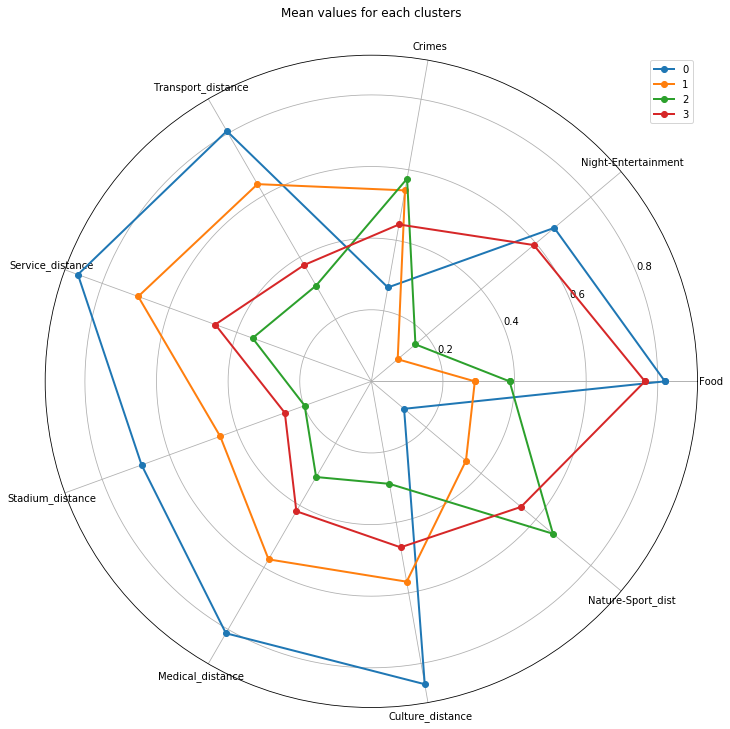

In [44]:
drawSpiderChart(df_clusters, serie_name='cluster')

In [45]:
tmp = pd.DataFrame(df_clusters.set_index("cluster").apply(computeArea, axis=1).sort_values(ascending=False))
tmp.columns = ["Area under spider curve"]
tmp

,Area under spider curve
cluster,
0,1.186447
3,0.692506
1,0.660738
2,0.356646


In [46]:
best_cluster = tmp.idxmax().values[0]
print("The best cluster number that seems to satisfy as much as possible the criteria of the cutomer would be: {0}".format(best_cluster))

The best cluster number that seems to satisfy as much as possible the criteria of the cutomer would be: 0


So the best cluster seems to be group 0. The disavantage is that the neighborhoods in cluster 0 are quite far from the Nature-sport venues and the crime rate is important.  
On the contrary the green curve (group 2) is close to the nature-sport venues and the crime rate is low.  
The red curve is more balanced but the values are to low.  
The choice is questionable but we decide to select the group 0

The graphs below represent the distribtion of the clusters for the 4 cities.  
We note that cluster 0 is only present in Toronto and San-Fransisco.  
So our first conclusion is to exlude NYC and Chicago.

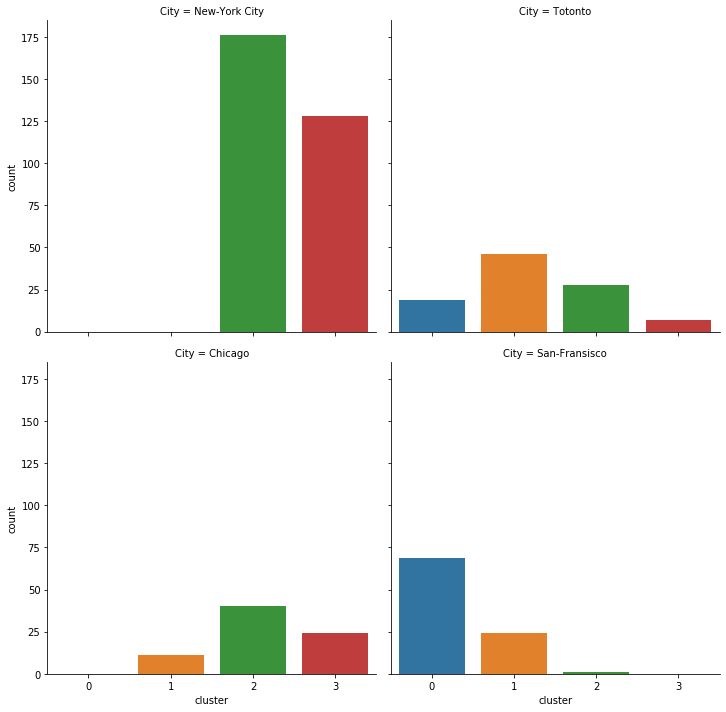

In [192]:
graph = sns.catplot(x="cluster", col="City", data=features_proc, kind="count", col_wrap=2)
graph.set_xticklabels(range(nb_clusters))

Now let's have a look at the positions of each neighborhoods with adding a new information: the cluster number.

In [47]:
centroid = np.mean([ny_lat,toronto_lat,chicago_lat,sf_lat]), np.mean([ny_long,toronto_long,chicago_long,sf_long])
print("centroid:", centroid)

centroid: (41.005383375, -90.85921992499999)


In [48]:
# create map
map_clusters = folium.Map(location=centroid, zoom_start=4)

# set color scheme for the clusters
x = np.arange(nb_clusters)
ys = [i + x + (i*x)**2 for i in range(nb_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(features_proc['Latitude'], features_proc['Longitude'], features_proc['Neighborhood'], features_proc['cluster']):
    label = folium.Popup(str(poi) + ' cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The neighborhoods of cluster 0 seems to be located in down town (SF & Toronto), but it's not a surprise reagrding the criteria. The neighborhoods of cluster 2 (close to nature-sport venues + low crime rate) are located on the outskirts of the city. Again it's not a surprise and it means the clustering is not so bad.


### Select the top-5 neighborhoods

Below, we extract the neighborhoods of group 0 and save them as a new dataframe called best_neighborhoods.  
We find 88 neighborhoods in group 0, that is quite important.

In [50]:
best_neighborhoods = features_proc[features_proc.cluster==best_cluster]
print("shape:", best_neighborhoods.shape)
best_neighborhoods.head()

shape: (88, 14)


,Neighborhood,Latitude,Longitude,City,Food,Night-Entertainment,Crimes,Transport_distance,Service_distance,Stadium_distance,Medical_distance,Culture_distance,Nature-Sport_dist,cluster
343,"The Danforth West, Riverdale",43.679557,-79.352188,Totonto,0.679992,0.671188,0.532030,0.702629,0.717889,0.532501,0.551499,0.730745,0.230850,0
345,Studio District,43.659526,-79.340923,Totonto,0.786247,0.578130,0.538609,0.672116,0.667633,0.518766,0.513824,0.753302,0.269599,0
353,"Cabbagetown, St. James Town",43.667967,-79.367675,Totonto,0.819647,0.578130,0.426416,0.684356,0.708463,0.552730,0.559827,0.850725,0.192667,0
354,Church and Wellesley,43.665860,-79.383160,Totonto,1.000000,0.867194,0.309756,0.669568,0.701261,0.561163,0.569503,0.901973,0.176959,0
355,"Harbourfront, Regent Park",43.654260,-79.360636,Totonto,0.623086,0.458157,0.426888,0.661587,0.671156,0.546299,0.530660,0.878666,0.226393,0


Since we have many neighborhoods to analyze, let's try the area method rather then exploring them one by one and plotting 88 curves on a spider chart.

In [51]:
tmp = pd.DataFrame(best_neighborhoods[FEATURES_COLS].apply(computeArea, axis=1).sort_values(ascending=False))
tmp.columns = ["Area under spider curve"]
tmp.head(5)

,Area under spider curve
557,1.471802
558,1.471454
487,1.463678
527,1.455424
559,1.449760


We computed the area under the spider curve and we selected the 5 neighborhoods which have the highest areas.  
The results is printed below:

In [52]:
best_neighborhoods_idx = tmp.index.values[:5]
print("The top-5 of the best neighborhoods that seems to satisfy as much as possible the criteria of the cutomer would be:")
top_5 = best_neighborhoods.loc[best_neighborhoods_idx, NEIGHBORHOOD_COLS]
top_5

The top-5 of the best neighborhoods that seems to satisfy as much as possible the criteria of the cutomer would be:


,Neighborhood,Latitude,Longitude,City
557,South Beach,37.779814,-122.391150,San-Fransisco
558,South of Market,37.780893,-122.400952,San-Fransisco
487,China Basin,37.776329,-122.391839,San-Fransisco
527,Lower Haight,37.771926,-122.432479,San-Fransisco
559,South Park,37.781590,-122.393975,San-Fransisco


The 5 neighborhoods are located in San-Francisco, we can take a glance at them on a map:

In [53]:
results = features_proc.copy(deep=True)
results["Top5"] = 0
results.loc[best_neighborhoods.index.values, "Top5"] = 1
results.loc[top_5.index.values, "Top5"] = 2

# create map
map_results = folium.Map(location=(sf_lat, sf_long), zoom_start=11)

# set color scheme for the Top5 column
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, top5 in zip(results['Latitude'], results['Longitude'], results['Neighborhood'], results['cluster'], results['Top5']):
    inTop5 = False
    if top5==2: inTop5 = True
    label = folium.Popup(str(poi) + ' cluster ' + str(cluster) + ' is in top-5: ' + str(inTop5), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[top5],
        fill=True,
        fill_color=rainbow[top5],
        fill_opacity=0.7).add_to(map_results)
       
map_results

## Results and Discussion <a name="results"></a>

Our analysis shows that the neighborhoods that satisfy as much as possible the criteria of the customer are located in San-Francisco or Toronto. We had 573 neighborhoods to evaluate and the clustering (into 4 groups) has helped us to filter the neighborhoods and we get 88 potential best neighborhoods. it is still a high number, maybe we need more features or more criteria to affine the clustering to get a greater number of clusters and a lower number of neighborhoods in the best cluster.
  
Eventually we identified the top-5 neighborhoods, all in San-Francisco. This city is often in the top 10 of the best places to live in USA according to various reviews or websites like cbsnews. So our choice seems to be consistent. 
The neighborhoods are located in downtown, we can see on the map that:
- there are many restaurants, parks and tram stations.
- We note the presence of the UCSF Medial Center that is close to these 5 neighborhoods and that should contribute to maximize the feature medical_distance. 
- We can find the Chase Center closed to this medical center. "The building is the home venue for the Golden State Warriors of the National Basketball Association (NBA).": <a href=https://en.wikipedia.org/wiki/Chase_Center>Wikipedia</a>.
- We also observe an important amount of museums, gellery arts very close to the northwest.
  
*Discussion:*  
In order to improve the selection of the best neighborhoods, we should transform the feature crimes that is the number of crimes reported in 2018 within a radius <= 500m from the neighborhood center.  
The problem is that neighborhoods have not the same population density, so it make sens to divide the number of crime by the population. The problem is obviously that censuses are not done every year and they are not set up in each city at the same time.
Thera also multiple ways to generate features from the criteria of the customer. We decide to count the distinct types of venues for some group of categories of venues, and to compute the average distance with other types of venues. To go deeper, it will be interesting to try other features like the minimum distance, etc.

## Conclusion <a name="conclusion"></a>

The objective of this project was to identify 5 neighborhoods for the company NAPE. This will help NAPE to focus on a few neighborhoods to find a land that should suits as much as possible the needs of a client who has planned to acquire a property soon.  

The first instructions was to focus on only 4 cities: Chicago, NYC, Toronto and San-Francisco.  
We used Foursquare and geopy module to explore the venues nearby each neighborhood of these cities and compute some features, and then by clustering the neighborhoods we managed to determine a group of neighborhoods to investigate in deeper. We used the representation of the features in spider chart to identify the best compromise and select the top-5 best neighborhoods.  

After a geographical analysis of these 5 neighborhoods, we identified on the map many venues that should meet the needs of the customer.